In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
file = 'cifar-100-python/train'
file2 = 'cifar-100-python/test'
train = unpickle(file)
test = unpickle(file2)
# print (len(data.get(b'filenames')))
# print (data.keys())

In [5]:
# print(pd.Series(data.get(b'coarse_labels')))
# print(test.keys())
test_label_c=pd.Series(test.get(b'coarse_labels'))
_testdata = pd.Series(x for x in test.get(b'data'))
test_label_f=pd.Series(test.get(b'fine_labels'))
images = pd.Series(test.get(b'filenames'))
test_df = pd.DataFrame(images , columns=['images'])
test_df['c_label'] = test_label_c
test_df['f_label'] = test_label_f
test_df['data'] =_testdata

In [6]:
c_label = pd.Series(train.get(b'coarse_labels'))
f_label = pd.Series(train.get(b'fine_labels'))
images = pd.Series(train.get(b'filenames'))
_traindata = pd.Series(x for x in train.get(b'data'))

In [7]:
df = pd.DataFrame(images , columns=['images'])
df['c_label'] = c_label
df['f_label'] = f_label
df['data'] =_traindata

In [8]:
def imageplot(rgb,i):
    img = np.array(rgb[i])
    # transform it to a 3 x 1024 array, one row per color channel 
    # and transpose it to a 1024 x 3 array, one row per rgb pixel
    img = img.reshape(3, 1024).T
    # reshape it so we can plot it as a 32 x 32 image with 3 color channels
    img = img.reshape(32, 32, 3)

    # plot
    plt.imshow(img)
    plt.show()

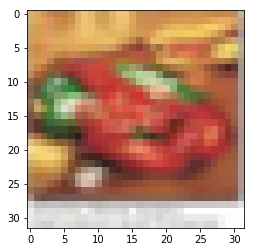

In [9]:
imageplot(_traindata,447)

In [10]:
test_df.head()

,images,c_label,f_label,data
0,b'volcano_s_000012.png',10,49,"[199, 196, 195, 195, 196, 197, 198, 198, 199, ..."
1,b'woods_s_000412.png',10,33,"[113, 88, 72, 63, 72, 100, 131, 149, 139, 132,..."
2,b'seal_s_001803.png',0,72,"[61, 61, 67, 62, 64, 63, 70, 73, 78, 88, 85, 7..."
3,b'mushroom_s_001755.png',4,51,"[93, 88, 104, 90, 74, 70, 70, 75, 77, 60, 61, ..."
4,b'adriatic_sea_s_000653.png',10,71,"[80, 80, 82, 86, 92, 97, 96, 97, 98, 99, 100, ..."


In [11]:
df.isnull().any()

images     False
c_label    False
f_label    False
data       False
dtype: bool

In [12]:
test_df.isnull().any()

images     False
c_label    False
f_label    False
data       False
dtype: bool

In [78]:
train_label=df['c_label']
test_label = test_df['c_label']

In [14]:
from __future__ import division

import warnings
from scipy import linalg

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, as_float_array
from sklearn.externals import six
class ZCA(BaseEstimator, TransformerMixin):
    def __init__(self, regularization=1e-6, copy=False):
        self.regularization = regularization
        self.copy = copy
    
    def fit(self, X, y=None):
        """Compute the mean, whitening and dewhitening matrices.
        Parameters
        X : array-like with shape [n_samples, n_features]
            The data used to compute the mean, whitening and dewhitening
            matrices.
        """
        def warn_if_not_float(X, estimator='This algorithm'):
            if not isinstance(estimator, six.string_types):
                estimator = estimator.__class__.__name__
            if X.dtype.kind != 'f':
                warnings.warn("%s assumes floating point values as input, "
                              "got %s" % (estimator, X.dtype))
                return True
            return False
        X = check_array(X, accept_sparse=None, copy=self.copy,
                        ensure_2d=True)
        if warn_if_not_float(X, estimator=self):
            X = X.astype(np.float)
        self.mean_ = X.mean(axis=0)
        X_ = X - self.mean_
        cov = np.dot(X_.T, X_) / (X_.shape[0]-1)
        U, S, _ = linalg.svd(cov)
        s = np.sqrt(S.clip(self.regularization))
        s_inv = np.diag(1./s)
        s = np.diag(s)
        self.whiten_ = np.dot(np.dot(U, s_inv), U.T)
        self.dewhiten_ = np.dot(np.dot(U, s), U.T)
        return self

    def transform(self, X, y=None, copy=None):
        """Perform ZCA whitening
        X : array-like with shape [n_samples, n_features]
            The data to whiten along the features axis.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X - self.mean_, self.whiten_.T)

    def inverse_transform(self, X, copy=None):
        """Undo the ZCA transform and rotate back to the original
        representation
        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to rotate back.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X, self.dewhiten_) + self.mean_
__all__ = ['ZCA']


In [67]:
X = train.get(b'data')# data array
X_test = test.get(b'data')
X = X.astype('float32')
X_test = X_test.astype('float32')
X=X/255
X_test=X_test/255

In [68]:

trf = ZCA().fit(X)
X_whitened = trf.transform(X)
X_whitened = (X_whitened-X_whitened.mean())/X_whitened.max()

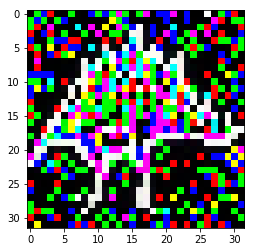

In [70]:
#image after whitening
imageplot(X_whitened,1)

In [71]:
# print(X_whitened)

trf = ZCA().fit(X_test)
X_whitened_test=trf.transform(X_test)
X_whitened_test = (X_whitened_test-X_whitened_test.mean())/X_whitened_test.max()

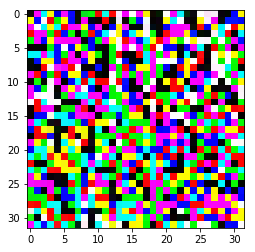

In [72]:
imageplot(X_whitened_test,1)

In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
# from keras_sequential_ascii import sequential_model_to_ascii_printout
import multiprocessing as mp
from keras import backend as K
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [73]:
# data array

X=X.reshape((len(X), 3, 32,32))
X=np.rollaxis(X,1,4)
# print(X)

In [74]:
X_test=X_test.reshape((len(X_test), 3, 32,32))
X_test=np.rollaxis(X_test,1,4)

In [75]:
batch_size = 32 
# 32 examples in a mini-batch, smaller batch size means more updates in one epoch
 
num_classes = 20 #
# repeat 100 times
lss = []

X_whitened=X_whitened.reshape((len(X_whitened), 3, 32,32))
X_whitened=np.rollaxis(X_whitened,1,4)
print(X_whitened)


[[[[  9.61304829e-03   6.40841783e-04   7.26881390e-03]
   [  6.56943861e-03  -4.53153625e-03  -2.33979896e-03]
   [  4.76851361e-03   5.29600168e-03  -7.79728696e-04]
   ..., 
   [ -1.88093390e-02  -5.23342527e-02  -1.73690263e-02]
   [  4.00871113e-02   5.77699989e-02   9.44441482e-02]
   [ -2.25356817e-02   2.24209893e-02  -2.05595773e-02]]

  [[  6.03851769e-03  -4.04966064e-03   5.26371319e-03]
   [  2.27352455e-02   4.51179873e-03   6.00538030e-03]
   [  2.22282120e-04   5.04520535e-03   9.55436286e-03]
   ..., 
   [  1.81957381e-03  -5.10323718e-02  -7.73388892e-02]
   [ -2.39936579e-02  -1.08712446e-02  -8.15724432e-02]
   [  1.14985825e-02   1.10397162e-02  -7.65399411e-02]]

  [[  1.00094285e-02  -1.11932131e-02   4.51797852e-03]
   [  7.30491662e-03   7.98882917e-03   8.29810835e-03]
   [ -1.16247556e-03   6.66895602e-03   1.80257694e-03]
   ..., 
   [  2.17330493e-02  -5.25063230e-03   8.80321637e-02]
   [  3.64470333e-02   7.76991025e-02  -2.25886311e-02]
   [ -5.93283735e

In [76]:

print(len(X_whitened_test))
X_whitened_test = X_whitened_test.reshape((len(X_whitened_test),3,32,32))
X_whitened_test = np.rollaxis(X_whitened_test,1,4)
# print(X_whitened_test)

10000


In [44]:
# X_whitened_test.reshape((len(X_whitened_test),3,32,32))

In [79]:
train_label = np_utils.to_categorical(train_label, num_classes)
test_label = np_utils.to_categorical(test_label, num_classes)
print(train_label)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]]


In [ ]:
epochs = 10
from keras import backend as K
K.set_image_dim_ordering('tf')
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32,3), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 10
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())


cnn = model.fit(X_whitened, train_label, batch_size=batch_size, epochs=epochs, validation_data=(X_whitened_test,test_label),shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
__________

In [145]:
from sklearn.metrics import accuracy_score
